In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
import altair as alt

pd.set_option('display.max_rows', 30)

Load the data tables

In [2]:
import requests
from zipfile import ZipFile
from io import BytesIO

## load the big loan data
loan_data_path = [f"https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_{i}.csv.zip" for i in range(3)]
rs = [requests.get(path) for path in loan_data_path]
files = [ZipFile(BytesIO(r.content)) for r in rs]
loan_data = []
i = 0 
for f in files:
    loan_data.append(pd.read_csv(f.open(f"kiva_loans_part_{i}.csv")))
    i += 1

## concat all parts of kiva_loan_data
df = pd.concat(loan_data)
df.head(2)


,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01


In [3]:
## load mpi_regional_location
mpi_df = pd.read_csv('https://raw.githubusercontent.com/aaubs/ds-master/main/data/assignments_datasets/KIVA/kiva_mpi_region_locations.csv')
mpi_df.head(2)

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538


Checking datatype, null values and clean the data, drop irrelevant columns if needed

In [4]:
# pd.concat([df.notnull().sum(), df.isna().sum(), df.dtypes], axis=1)
pd.DataFrame({'non_null_count': df.notnull().sum(), 'null_count':df.isna().sum(), 'dtypes': df.dtypes}).drop('Unnamed: 0', axis=0)

,non_null_count,null_count,dtypes
id,671205,0,int64
funded_amount,671205,0,float64
loan_amount,671205,0,float64
activity,671205,0,object
sector,671205,0,object
use,666973,4232,object
country_code,671197,8,object
country,671205,0,object
region,614405,56800,object
currency,671205,0,object


Columns like 'use', 'tag' can be valuable for us to analyzie the purpose of the loan using NLP, but first, we will just focus on other patterns to better understand the dataset. So we can just ignore the missing value in these 2 columns

For loan that do not have a disbursed_time and funded_time, that means the borrower has received no money or just a proportion of their desired amount. To look at the time for a loan to be disbursed, we will drop null values in these 2 columns too.

In [16]:
df.dropna(subset=['borrower_genders', 'country_code', 'disbursed_time', 'funded_time'], inplace=True)
df = df[['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'country', 'region',
         'posted_time', 'disbursed_time', 'funded_time', 'term_in_months', 
         'lender_count',  'borrower_genders', 'repayment_interval']]

In [93]:
pd.DataFrame({'non_null_count': mpi_df.notnull().sum(), 'null_count':mpi_df.isna().sum(), 'dtypes': mpi_df.dtypes})

,non_null_count,null_count,dtypes
LocationName,984,1788,object
ISO,1008,1764,object
country,1008,1764,object
region,984,1788,object
world_region,1008,1764,object
MPI,984,1788,float64
geo,2772,0,object
lat,892,1880,float64
lon,892,1880,float64


The MPI table has a lot of null values. Here, we care about 3 main columns: country, region and mpi. We will remove null records for those columns

In [17]:
mpi_df = mpi_df[['country', 'region', 'MPI']].dropna()

### Loan Amount Analysis

([<matplotlib.axis.XTick at 0x26bd0f960b0>,
 [Text(0, 0, 'Funded Amount'), Text(1, 0, 'Loan Amount')])

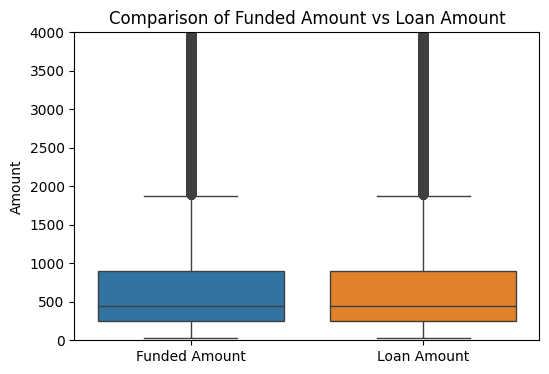

In [18]:
## Plot two box-plots to compare the distribution of loan_amount and funded_amount
plt.figure(figsize=(6, 4))
sns.boxplot(data=df[['funded_amount', 'loan_amount']])
plt.title('Comparison of Funded Amount vs Loan Amount')
plt.ylabel('Amount')
plt.ylim(0,4000)
plt.xticks([0, 1], ['Funded Amount', 'Loan Amount'])


In [19]:
## Using the IQR method to remove outliers
Q1 = np.percentile(df['loan_amount'], 25, method='midpoint')
Q3 = np.percentile(df['loan_amount'], 75, method='midpoint')
IQR = Q3 - Q1
# Finding the upper and lower bound
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

print('before:', len(df))
# Remove outliers
df = df[(df['loan_amount'] < upper) & (df['loan_amount'] > lower)]
print('after:', len(df))

before: 619307
after: 566672


In [20]:
## Calculate the difference between loan_amount and funded_amount
df['amount_diff'] = df['loan_amount'] - df['funded_amount']
df.groupby('amount_diff')['id'].count()

amount_diff
0.0    566672
Name: id, dtype: int64

Funded amount is the amount disbursed by Kiva to the field agent (USD).
Loan amount is the amount disbursed by the field agent to the borrower (USD)
The loan_amount is all the same as funded_amount, which indicates that field agents only use Kiva's money to finance the borrowers.


##### Break down by country and sector

In [24]:
# average loan amount by country
mean_amt_country = df.groupby('country').agg({'loan_amount':'mean'}).reset_index()
mean_amt_country = mean_amt_country.sort_values('loan_amount', ascending=False)
print(mean_amt_country.head())

    country  loan_amount
13    Congo  1850.000000
27   Israel  1659.782609
8   Burundi  1576.890756
11    China  1391.875000
74  Vanuatu  1375.000000


In [39]:
# visualize the average via a world map
data = [ dict(
        type = 'choropleth',
        locations = mean_amt_country['country'],
        locationmode = 'country names',
        z = mean_amt_country['loan_amount'],
        text = mean_amt_country['country'],
        colorscale='Inferno',
        reversescale=False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.0
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Average Loan Amount'),
      ) ]

## Adding everything to the layout, setting title, margin, color, etc...
layout = dict(
    title = 'Average Loan Amount by Country (USD)',
    margin = dict(
                l=0,
                r=0,
                b=0,
                t=30,
                pad=0,
                autoexpand=True
            ),
    geo = dict(
        showframe = False,
        showcoastlines = True,
        showlakes = True,
        landcolor='rgb(240, 240, 240)',
        oceancolor='rgb(224, 235, 255)',
        showocean=True,
        projection = dict(
            type = 'Mercator'
        )
    )
)
fig = dict( data=data, layout=layout )
iplot(fig, validate=False)

It is clear that Kiva operates in poorer reagions of the world and left out reach countries in Asia, Europe. America, however, is quite active in the map. This can be because of the country's high level of income inequality.

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x='sector', y='loan_amount', data=df)
plt.xticks(rotation=45)
plt.title("Loan Amount by Sectors", fontsize=15)
plt.xlabel("")
plt.ylabel("Loan amount", fontsize=12)

Text(0, 0.5, 'Loan amount')

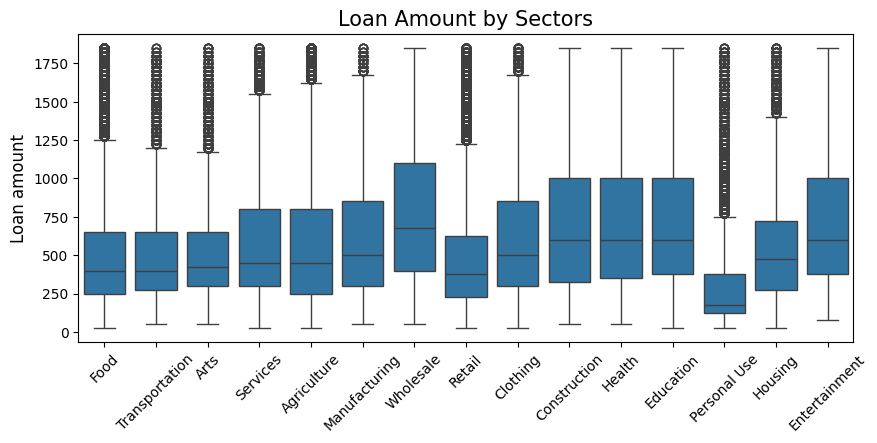

In [53]:
# visualize the average loan amount by sectors
plt.figure(figsize=(10,4))
sns.boxplot(x='sector', y='loan_amount', data=df)
plt.xticks(rotation=45)
plt.title("Loan Amount by Sectors", fontsize=15)
plt.xlabel("")
plt.ylabel("Loan amount", fontsize=12)

Wholesale, Contruction, Health and Education are the top sectors with high loan amount. This may indicate that in th poor regions, people often encounter financial difficulty when opening a business, buidling houses, accessing healthcare and education, which is also a common trait of underdeveloped area

### Analyzing number of loan

In [64]:
## The same as above, visualise number of loan by country in a geo heatmap
loan_country = df.groupby('country').agg({'id':'count'}).reset_index().rename(columns={'id': 'number_of_loan'})
data = [ dict(
        type = 'choropleth',
        locations = loan_country['country'],
        locationmode = 'country names',
        z = loan_country['number_of_loan'],
        text = loan_country['country'],
        colorscale='Inferno',
        reversescale=False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.0
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Number of Loans'),
      ) ]

## Adding everything to the layout, setting title, margin, color, etc...
layout = dict(
    title = 'Total number of Loans by Country',
    margin = dict(
                l=0,
                r=0,
                b=0,
                t=30,
                pad=0,
                autoexpand=True
            ),
    geo = dict(
        showframe = False,
        showcoastlines = True,
        showlakes = True,
        landcolor='rgb(240, 240, 240)',
        oceancolor='rgb(224, 235, 255)',
        showocean=True,
        projection = dict(
            type = 'Mercator'
        )
    )
)
fig = dict( data=data, layout=layout )
iplot(fig, validate=False)

Number of loan by loan_terms and sectors. Does one sector have shorter term than the others?

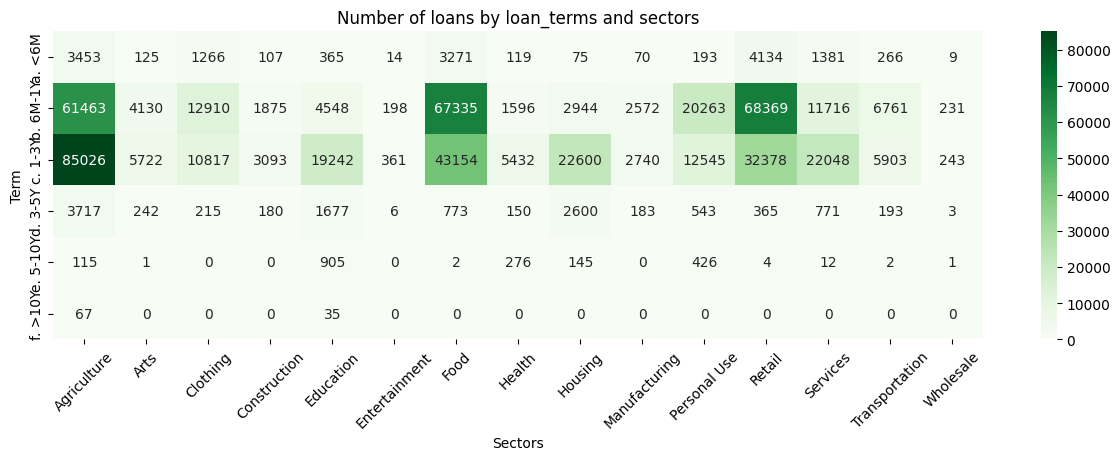

In [62]:
## Create the data for heatmap, counting number of loans by loan_term and sector

## Remapping term_in_months to specific loan_term groups
df['loan_term'] = np.where(df['term_in_months'] < 6, 'a. <6M', 
                           np.where(df['term_in_months'] <= 12, 'b. 6M-1Y', 
                                np.where(df['term_in_months'] <= 36, 'c. 1-3Y', 
                                             np.where(df['term_in_months'] <= 60, 'd. 3-5Y', 
                                                      np.where(df['term_in_months'] <= 120, 'e. 5-10Y', 'f. >10Y')))))

## Tranform data to plot                           
heatmap_data = df.pivot_table(index='loan_term', columns='sector', aggfunc='size', fill_value=0)

## Plot the heatmap
plt.figure(figsize=(15, 4))
sns.heatmap(heatmap_data, cmap='Greens', annot=True, fmt='d')
plt.title('Number of loans by loan_terms and sectors')
plt.xlabel('Sectors')
plt.ylabel('Term')

plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.show()


In [6]:
bin_edges = [0, 6, 12, 36, 60, 120]
bin_labels = ['< 6M', '6M - 1Y', '1-3 Y', '3-5 Y', '5-10 Y']
df['loan_term'] = pd.cut(df['term_in_months'], bins=bin_edges, labels=bin_labels, right=False)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9412\142991859.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<BarContainer object of 5 artists>

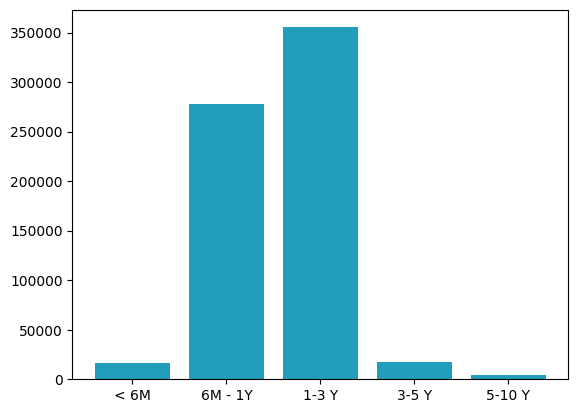

In [14]:
test = df.groupby('loan_term')['id'].count().reset_index()
plt.bar(test['loan_term'], test['id'], color='#219EBC')


Algriculture, Education, Housing tend to have more longer terms than other sectors

### Time-series

In [ ]:
## Change the datatype of the datetime columns
date_cols = ['posted_time', 'disbursed_time', 'funded_time']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [ ]:
## Extracting the year-month of disbursed time
df['disbursed_time_formatted'] = df['disbursed_time'].dt.strftime('%Y-%m')

## Aggregate data before plotting
data = df.groupby('disbursed_time_formatted')[['loan_amount', 'id']].agg({'loan_amount':['sum', 'mean'], 'id':'count'})
data.columns = data.columns.droplevel(0)
data.reset_index(inplace=True)

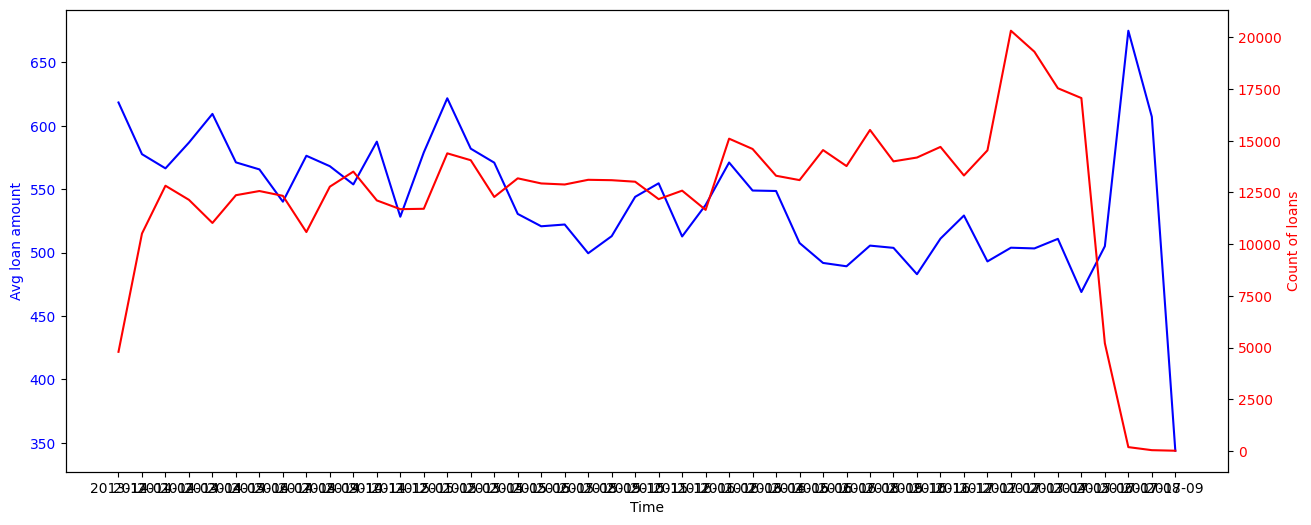

In [89]:
# Create figure and axis for the first y-axis
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(15)
# Plot the avg_amount line on the left y-axis
ax1.plot(data['disbursed_time_formatted'], data['mean'], label = "avg_amount", color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg loan amount', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second line on the right y-axis
ax2.plot(data['disbursed_time_formatted'], data['count'], label = "count", color='r')
ax2.set_ylabel('Count of loans', color='r')
ax2.tick_params(axis='y', labelcolor='r')

It can be seen that number of loans and the average loan amount have different tendency overtime.

Text(0.5, 1.0, 'Total loan amount overtime')

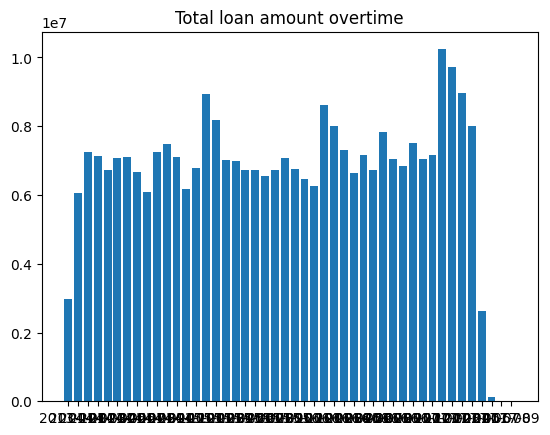

In [91]:
plt.bar(data['disbursed_time_formatted'], data['sum'])
plt.title('Total loan amount overtime')

### How long does it take for a loan to be disbursed?

In [21]:
## Calculate number of days between the dates
df['day_to_dibursed'] = (df['disbursed_time'] - df['posted_time']) / np.timedelta64(1, 'D')
df['day_to_funded'] = (df['funded_time'] - df['disbursed_time']) / np.timedelta64(1, 'D')

In [15]:
## It's weird that most of the loans have disbused_time BEFORE posted_time
(df['day_to_dibursed'] < 0).value_counts()

True     624422
False     46783
Name: day_to_dibursed, dtype: int64

From Kiva's website: "Once a loan is approved by the Field Partner, the Field Partner takes a picture of the borrower, provides a description of the loan use, and posts the profile information of that borrower to Kiva for funding." Therefore, the above-mentioned pattern is not normal. Maybe we need to understand more about the business process of Kiva, or maybe it is just that they allow late update of the profiles on their website.

We will just look at the time from first disbursement to fullly funded

In [47]:
## Filter out loans that have funded_time < disbursed_time
df_days = df[~((df['day_to_funded'].isna()) | (df['day_to_funded'] < 0))]
len(df_days)

590800

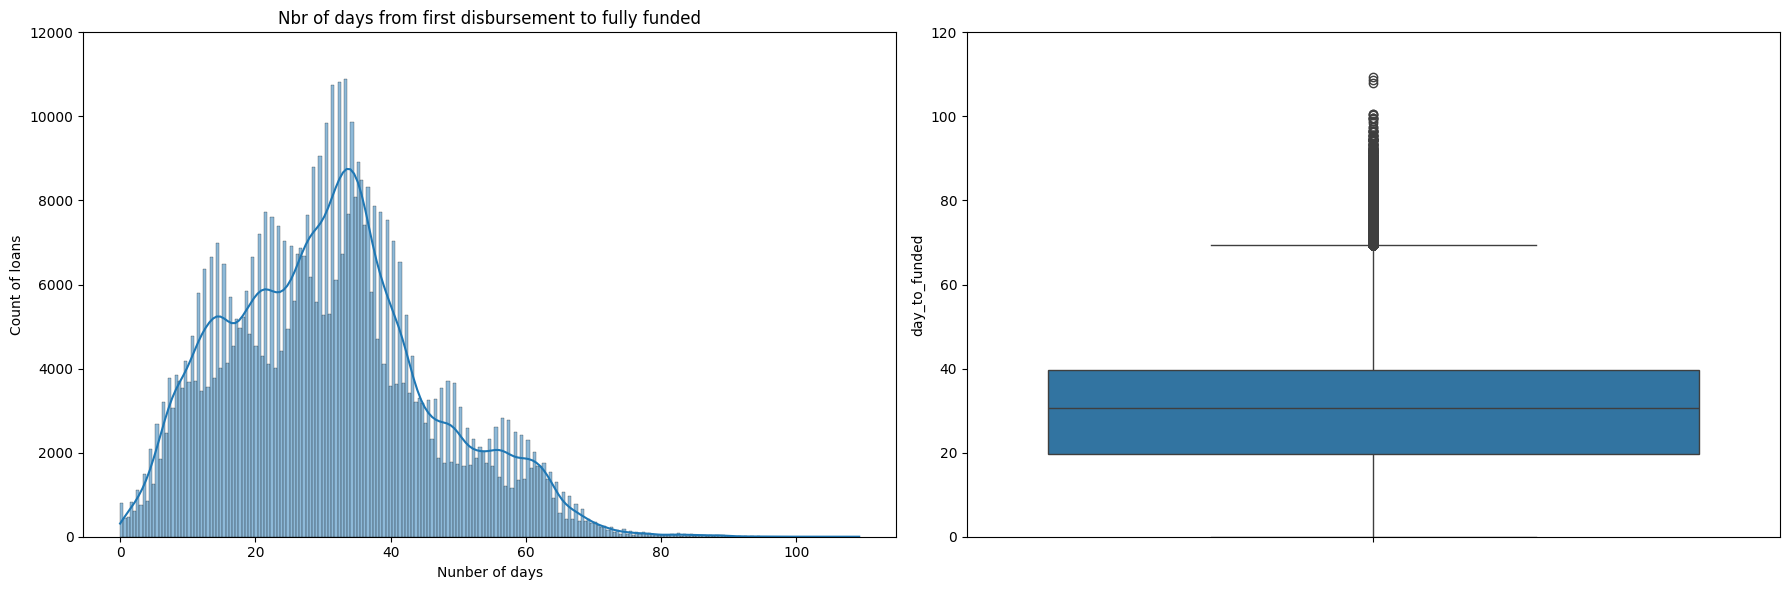

In [29]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

## for the 2 plot to share the same y-axis, use param sharey = True

# Plot histogram for day_to_funded 
sns.histplot(df_days['day_to_funded'], kde=True, ax=axes[0])
axes[0].set_title('Nbr of days from first disbursement to fully funded')
axes[0].set_xlabel('Nunber of days')
axes[0].set_ylabel('Count of loans')
axes[0].set_ylim(0, 12000)

# Plot boxplot
sns.boxplot(y='day_to_funded', data=df_days, ax=axes[1])
axes[1].set_ylim(0, 120)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

So a loan can normally take 0-60 days to be fully funded. So what can affect this? Some variables might be:
- number of lender
- the month of that the loan first dibursed

But first, we need to get rid of the outliers in order to perfrom some test 

In [31]:
## Using the IQR method to remove outliers
Q1 = np.percentile(df_days['day_to_funded'], 25, method='midpoint')
Q3 = np.percentile(df_days['day_to_funded'], 75, method='midpoint')
IQR = Q3 - Q1

# Finding the upper bound
upper = Q3 + 1.5*IQR
# Remove outliers
df_days = df_days[df_days['day_to_funded'] < upper]
len(df_days)

586531

So we just removed 590800 - 586531 = 4269 outliers ~ 0.72%

Month vs days_to_fully_funded

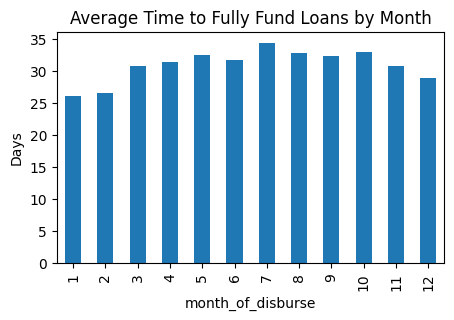

In [43]:
df_days['month_of_disburse'] = df_days['disbursed_time'].dt.strftime('%m').astype('int')

# Group by month and calculate the average number of days to fully fund loans
monthly_funding_time = df_days.groupby('month_of_disburse')['day_to_funded'].mean()

# Plot the result
plt.figure(figsize=(5, 3))
monthly_funding_time.plot(kind='bar', title='Average Time to Fully Fund Loans by Month', ylabel='Days')
plt.show()

We do not see much differences between the month. Let's check the number of lender

In [50]:
## Using the IQR method to remove outliers in lender_count
Q1 = np.percentile(df_days['lender_count'], 25, method='midpoint')
Q3 = np.percentile(df_days['lender_count'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
df_days = df_days[(df_days['lender_count'] < upper) & (df_days['lender_count'] > lower) ]

## Check the remaining data
print(len(df_days))
print(df_days['lender_count'].describe())

526825
count    526825.000000
mean         13.921720
std           9.822795
min           1.000000
25%           7.000000
50%          11.000000
75%          19.000000
max          41.000000
Name: lender_count, dtype: float64


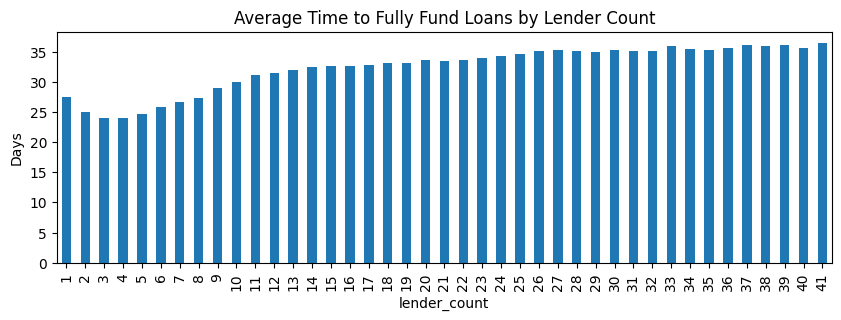

In [52]:
## Plot to show any connection between number of lender and time to fully fund
lender = df_days.groupby('lender_count')['day_to_funded'].mean()
plt.figure(figsize=(10, 3))
lender.plot(kind='bar', title='Average Time to Fully Fund Loans by Lender Count', ylabel='Days')
plt.show()

There might be difference between loans with <= 10 lender and the other, so let's run a test

- H0: it takes the same amount of time for loan with no more than 10 lender to be fully funded
- HA: there's a difference between the 2 group

In [53]:
from scipy import stats

# Extract fare data for the two groups: survivors and non-survivors
no_more_10_lenders = df_days[df_days['lender_count'] <= 10]['day_to_funded'].dropna()
more_than_10_lenders =  df_days[df_days['lender_count'] > 10]['day_to_funded'].dropna()

# Perform a t-test
t_stat, p_value = stats.ttest_ind(no_more_10_lenders, more_than_10_lenders)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -170.0338811190047
P-value: 0.0


With 1% significant level, p_value < alpha so we can conclude that "There is a difference in days to be fully funded between loans with no more than 10 lenders and others.

### Are there any link among the loan amount, number of loans, number of lenders and a region's MPI

In [106]:
## Find the number of loan and lenders in each region
df_region = df.groupby(['country', 'region']).agg({'loan_amount':'sum', 'id':'count',  'lender_count':'sum'})\
            .rename(columns={'id':'nbr_loans', 'lender_count':'nbr_lenders'})
df_region.reset_index(inplace=True)
print('Before joining', len(df_region))

## Join to find the MPI of each region
df_region = df_region.merge(mpi_df, on=['country', 'region'])
print('After joining', len(df_region))

Before joining 12749
After joining 110


We only have data left for 110 regions, because the mpi table has very limited data.
We will visualize the correlation matrix between the 3 variables

In [110]:
correlation_matrix = df_region[['loan_amount', 'nbr_loans', 'nbr_lenders', 'MPI']].corr(method = 'spearman')
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# plt.figure(figsize=(5,3))
# sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='crest').set_title('Correlation Matrix')

correlation_matrix

,loan_amount,nbr_loans,nbr_lenders,MPI
loan_amount,1.000000,0.947285,0.997142,-0.171330
nbr_loans,0.947285,1.000000,0.954716,-0.110812
nbr_lenders,0.997142,0.954716,1.000000,-0.162949
MPI,-0.171330,-0.110812,-0.162949,1.000000


It is totally understandable for the strong positive correlation between the number of loans and the number of lenders and loan amount

As for MPI, the relationships are relatively weak. But all are negative correlation. It shows that the higher MPI, the fewer loans a region has.
So that indicates 'poorer people borrow less'. Kiva might want to change the situation because their aim is to target poor and financially excluded people.